# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [9]:
USER_NAME = u"Крылов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", " Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода%s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

$$
g(x,w) = w_0 + \sum_{j=1}^d w_j x_j; \, h(x,w) = \sigma(g(x,w))
$$

$$
L_{Lasso}(w) = -\frac{1}{n} \sum_{i=1}^n \log(\sigma(y_i \, g(x_i,w))) + \frac{1}{C} \sum_{j=0}^d | w_j |
$$
$$
\frac{\partial L}{\partial w_0} = \frac{w_0}{|w_0|C}−\frac{1}{n}\sum_{i=1}^n\frac{y_i}{e^{g(x_i,w)y_i}+1}
$$
$$
\frac{\partial L}{\partial w_j} = \frac{w_j}{|w_j|C}−\frac{1}{n}\sum_{i=1}^n\frac{x_{ij} y_i}{e^{g(x_i,w)y_i}+1} \, \forall j = 1 \dots d
$$

# Реализация модели

## Имплементация (6 баллов)

In [50]:
from sklearn.base import BaseEstimator, ClassifierMixin
from time import asctime

def _sigma(z):
    return 1/(1+np.exp(-z))

def _Xtrick(X): # add zeroth column to account for w_0
    return np.c_[np.ones(X.shape[0]),X]

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.L = np.empty(max_epoch)

    # L and L'_w require X, y and w to be matrices of specific dimensions to be fast
    def _L_grad(self,X,y):
        return \
            np.sign(self.weights)/self.C \
            -np.sum(
                X*y
                / (1 + np.exp(X.dot(self.weights)*y)),
                axis=0
            ).reshape(-1,1)/X.shape[0]
    
    def _L(self,X,y):
        return \
            -np.sum(np.log(_sigma(y*X.dot(self.weights))))/X.shape[0] \
            +np.sum(np.abs(self.weights))/self.C
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.weights = np.random.rand(X.shape[1]+1,1)
        return self.partial_fit(X, y)
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        Xlocal = _Xtrick(X)
        ylocal = np.c_[y]
        print 0, asctime(), self._L(Xlocal,ylocal), self.weights[:,0]
        indices = range(Xlocal.shape[0])
        for epoch in xrange(self.max_epoch):
            np.random.shuffle(indices)
            for i in indices:
                self.weights -= self.alpha/(epoch+1) * self._L_grad(Xlocal,ylocal)
            self.L[epoch] = self._L(Xlocal,ylocal)
            print epoch+1, asctime, self.L[epoch], self.weights[:,0]
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        return np.sign(_Xtrick(X).dot(self.weights))
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        return _sigma(_Xtrick(X).dot(self.weights))

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

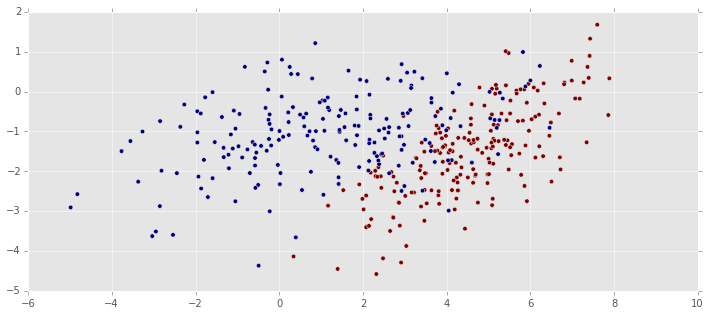

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
#y = np.r_[np.ones(200), np.zeros(200)] # hmm, aren't our classes +1 and -1?
y = np.r_[np.ones(200), -np.ones(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [5]:
np.random.seed(42)
model = MySGDClassifier(alpha=.25,C=45,max_epoch=200) # with 200 epochs it seems to be pretty stable in regard to params
%time model.fit(X, y)

CPU times: user 15.9 s, sys: 60 ms, total: 15.9 s
Wall time: 16.8 s


MySGDClassifier(C=45, alpha=0.25, max_epoch=200)

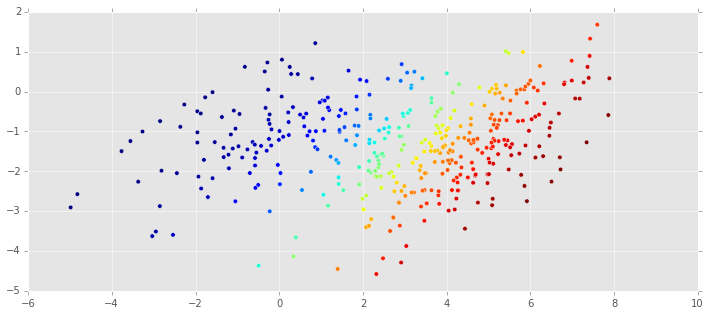

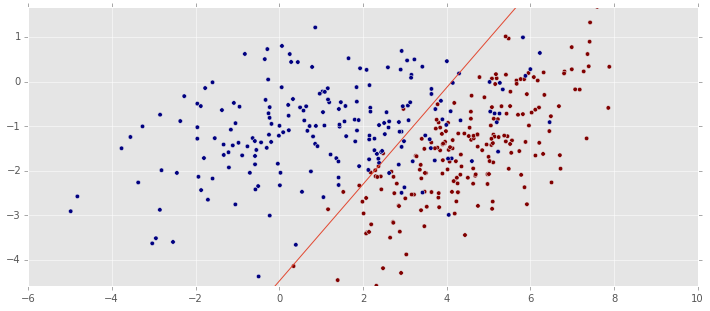

In [6]:
plt.figure()
plt.scatter(X[:,0],X[:,1],c=model.predict_proba(X))

plt.figure()
plt.scatter(X[:,0],X[:,1],c=y)
plt.ylim(X[:,1].min(),X[:,1].max())
Xline = np.linspace(X[:,0].min(),X[:,0].max())
plt.plot(Xline,-(model.weights[0]+model.weights[1]*Xline)/model.weights[2])

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

CPU times: user 57.7 s, sys: 64 ms, total: 57.8 s
Wall time: 1min 1s


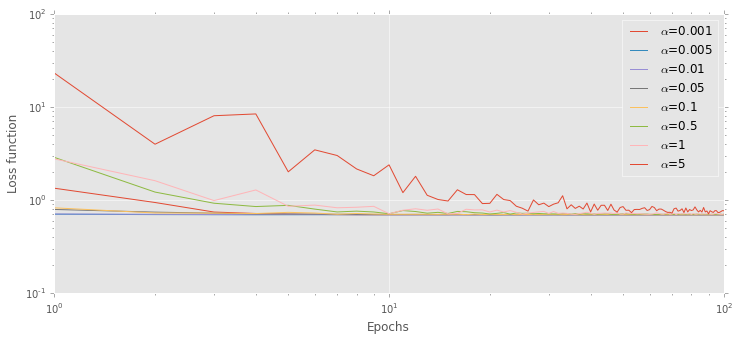

In [155]:
%%time
EPOCHS=100
plt.figure()
for alpha in [.001, .005, .01, .05, .1, .5, 1., 5.]:
    np.random.seed(42)
    plt.plot(range(1,EPOCHS+1),MySGDClassifier(alpha=alpha,max_epoch=EPOCHS).fit(X,y).L,label='$\\alpha$=%g'%alpha)
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss function")
plt.xscale("log")
plt.yscale("log")

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [3]:
df_data = pd.read_csv('trainingData_tabular_chunk1.csv.gz', sep=',')

In [4]:
df_data.shape

(500000, 45)

In [5]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [6]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [8]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50470199999999998

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [31]:
# that's assuming I understood the question
print "Уникальных карт героя у игрока: %d, у противника: %d" % (
    df_data.player_hero_card_id.value_counts().count(),
    df_data.opponent_hero_card_id.value_counts().count()
)

Уникальных карт героя у игрока: 9, у противника: 9


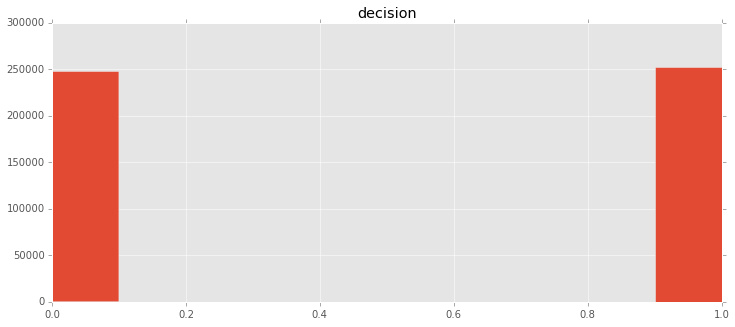

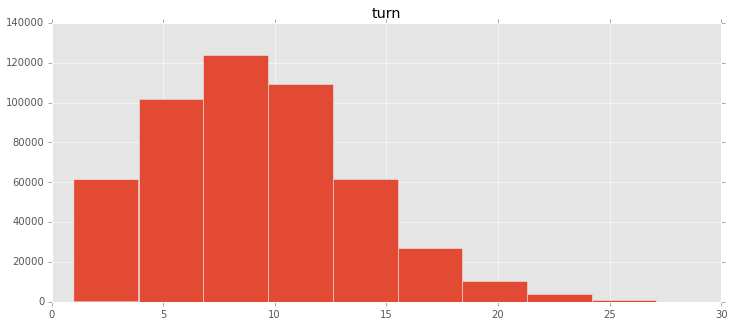

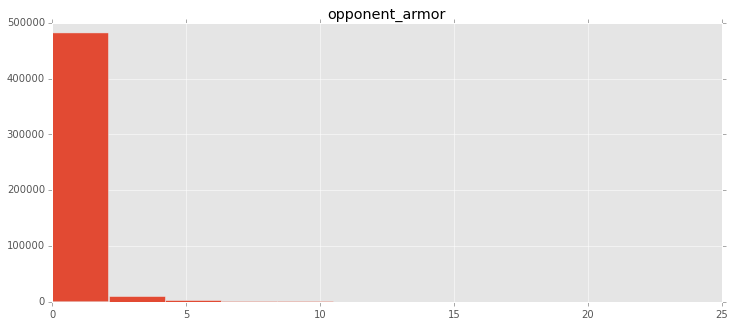

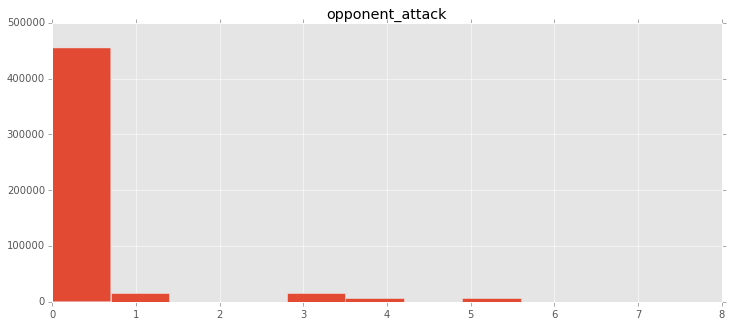

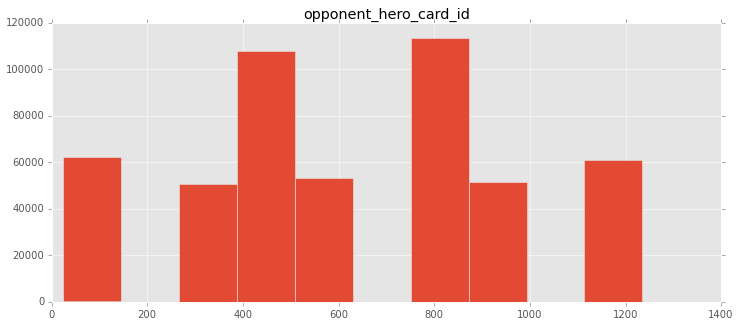

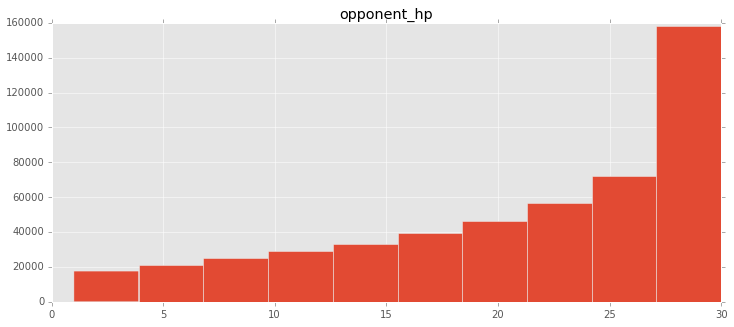

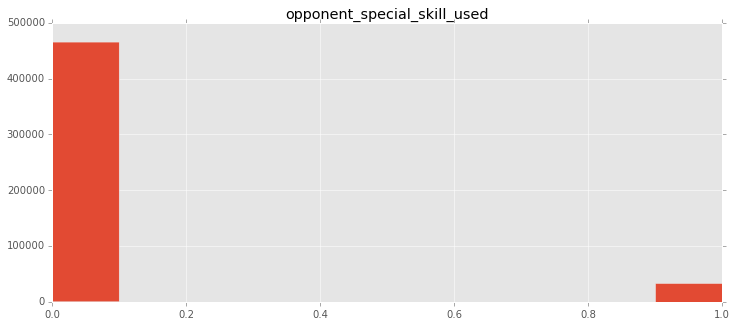

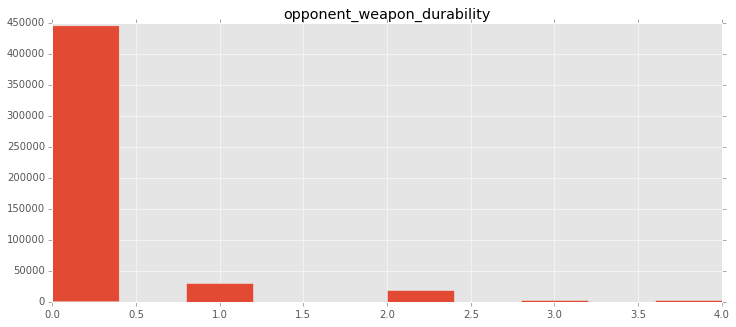

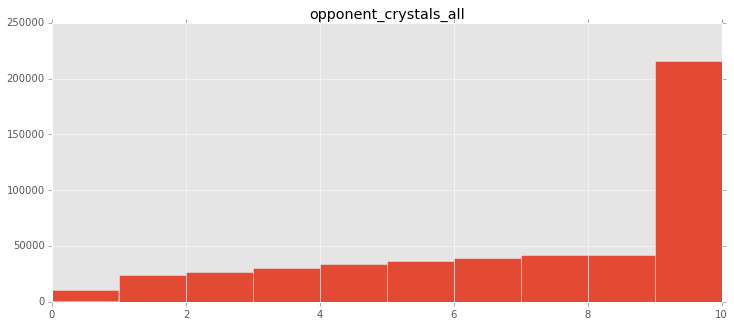

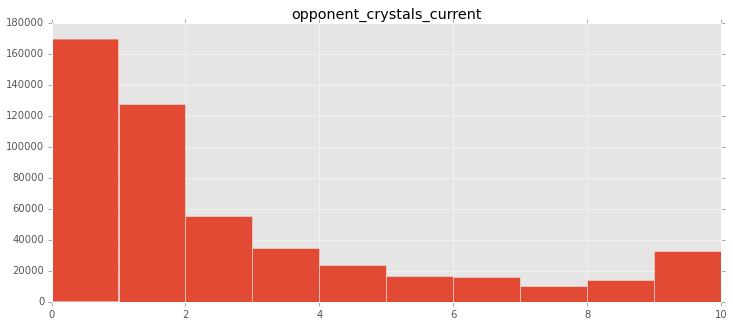

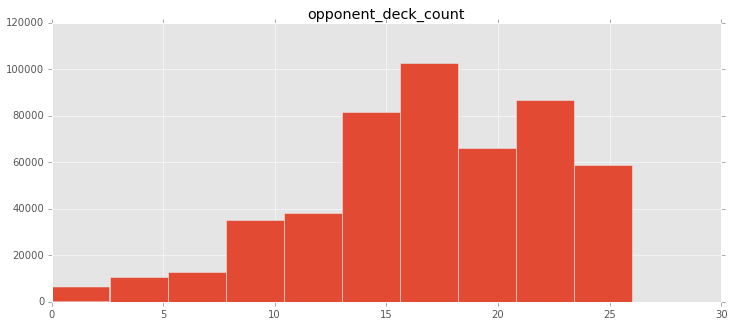

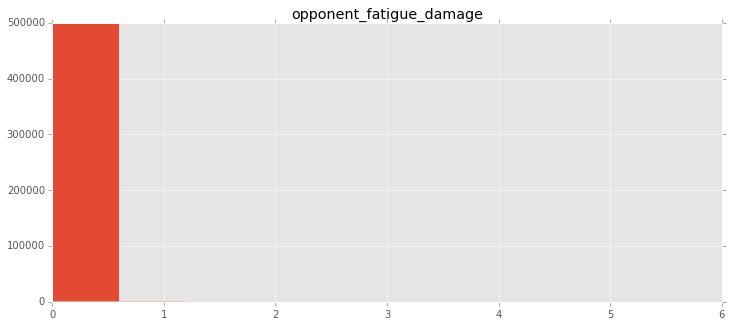

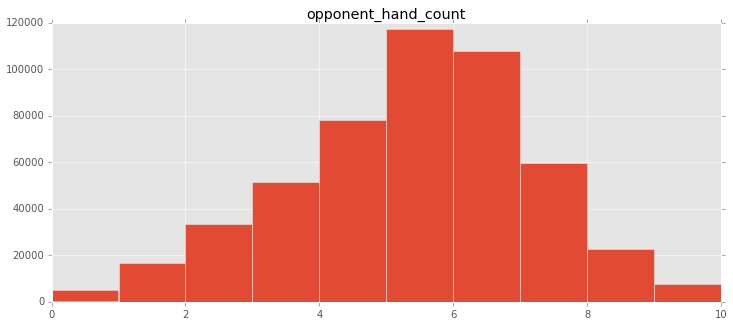

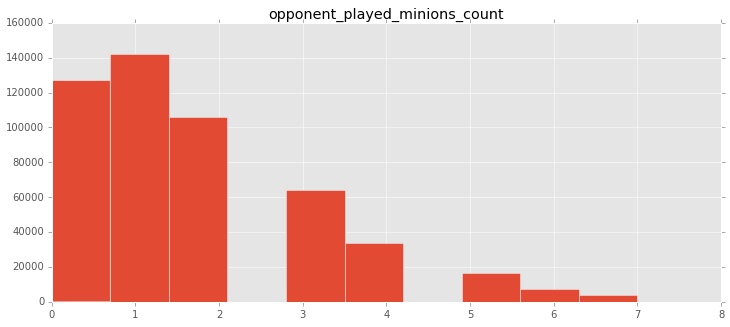

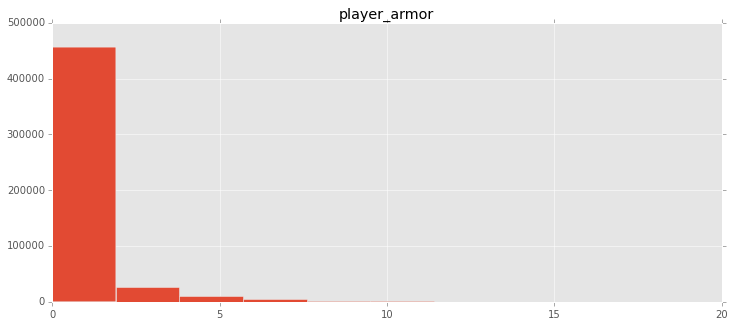

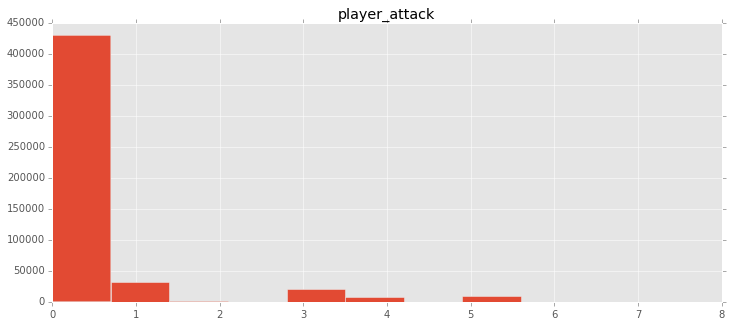

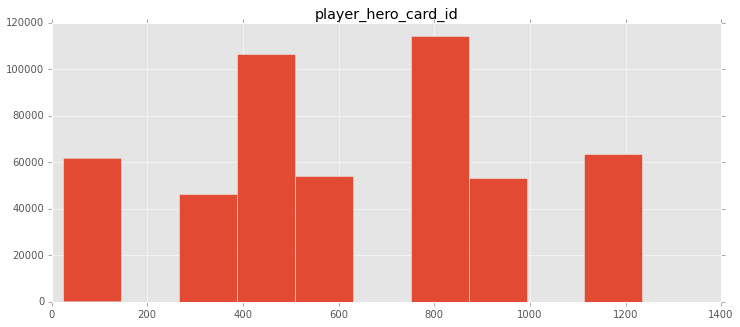

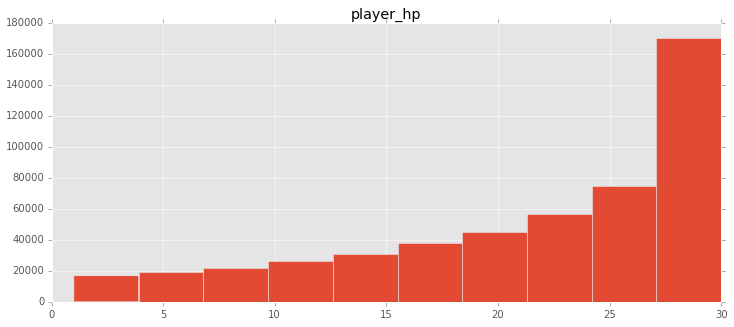

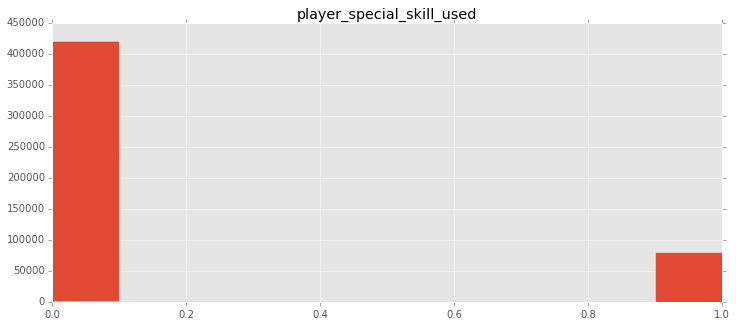

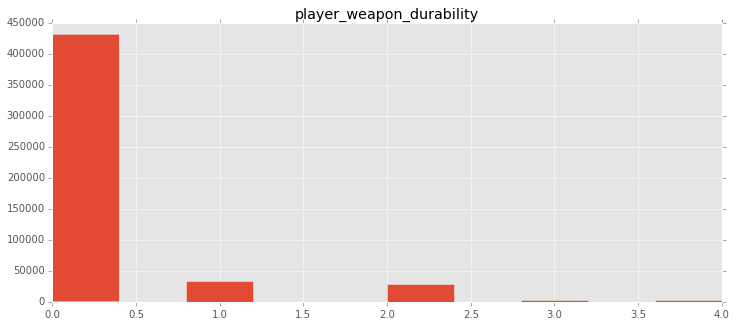

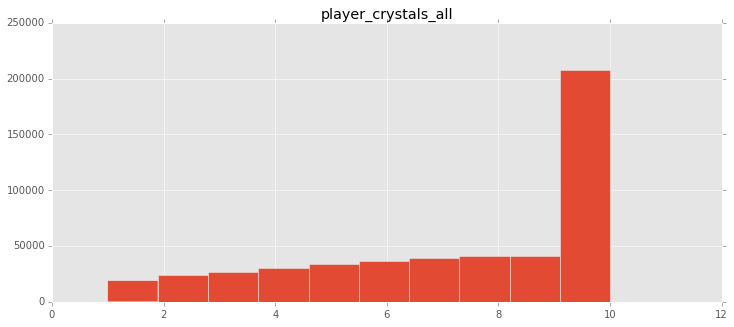

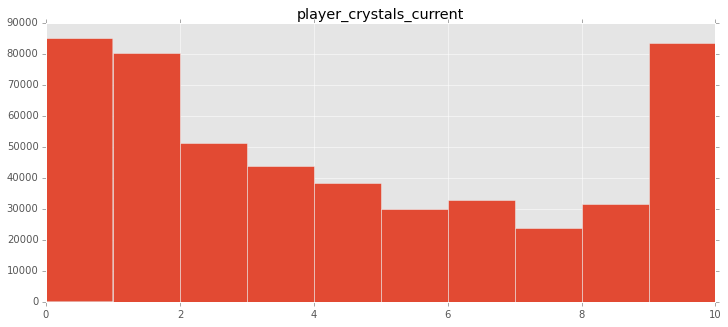

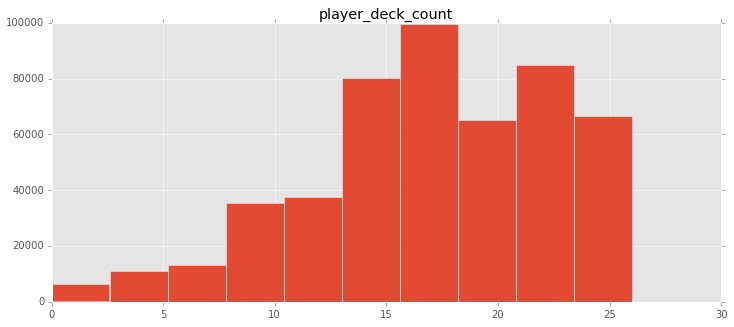

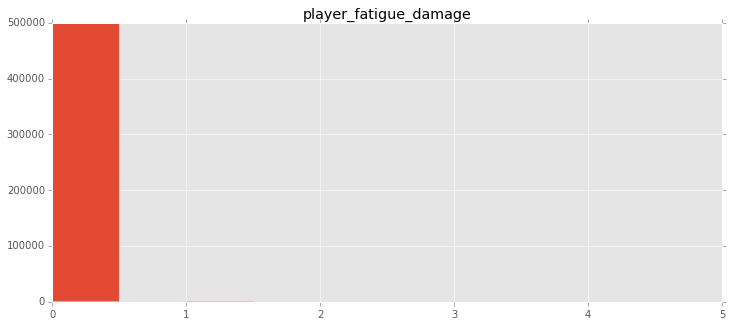

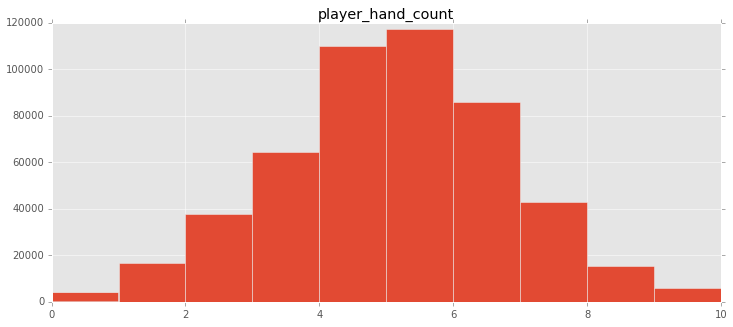

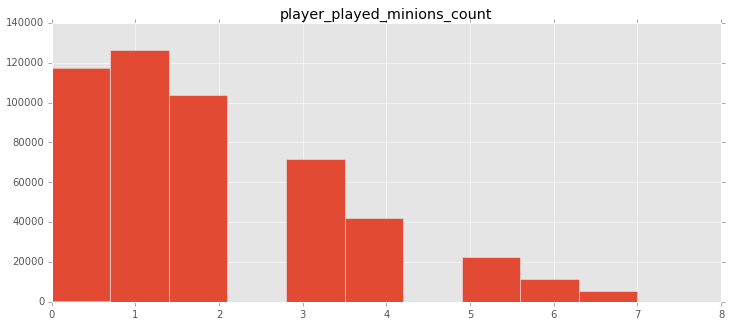

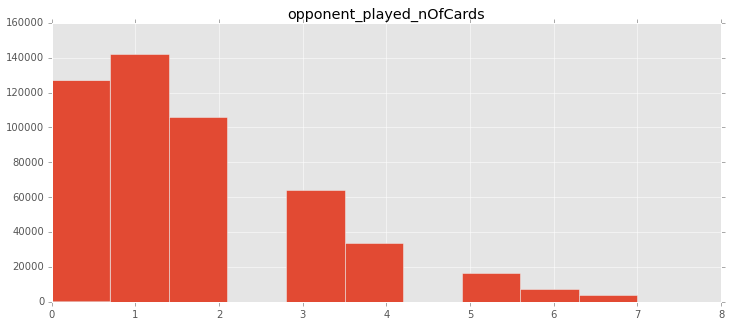

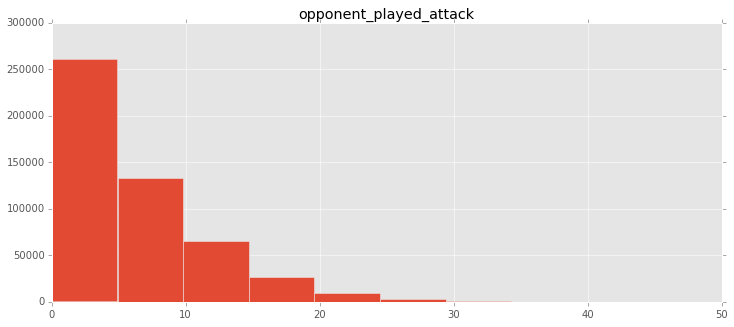

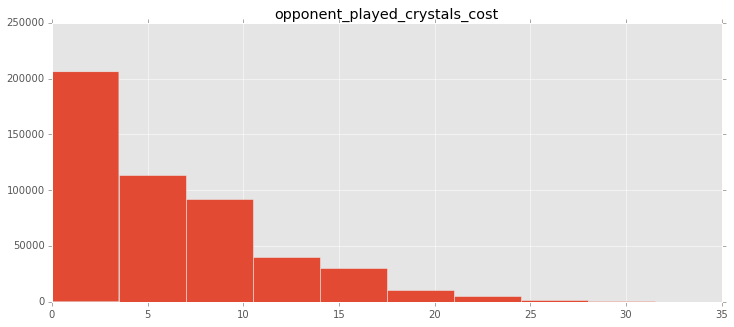

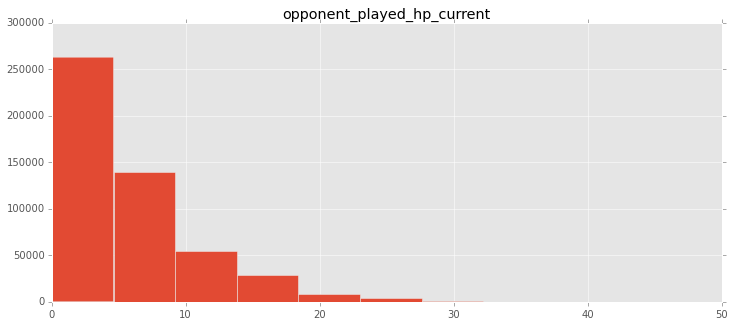

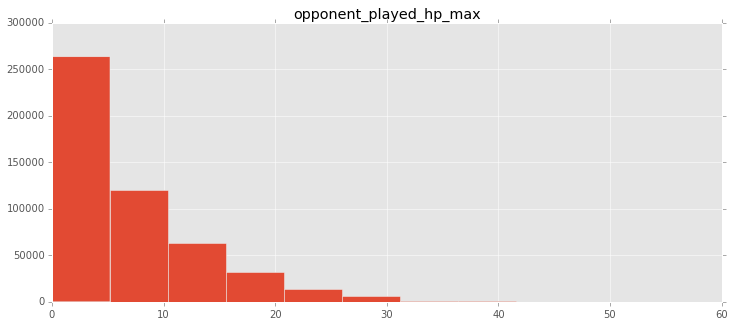

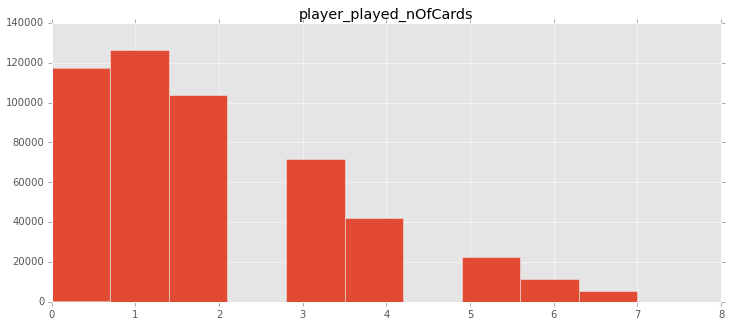

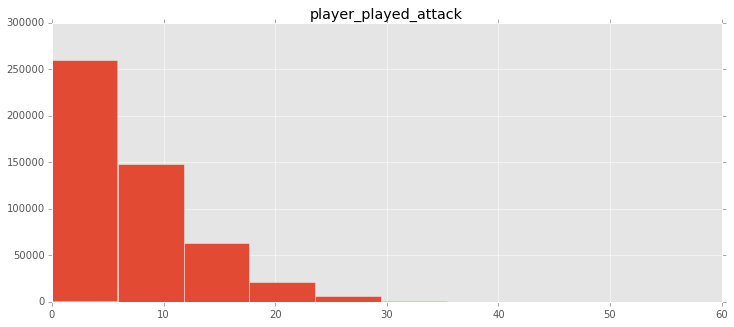

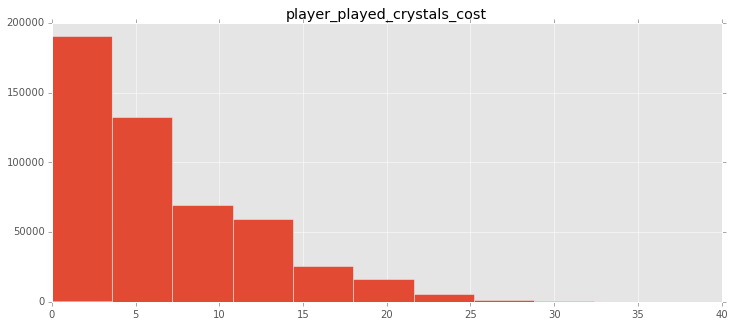

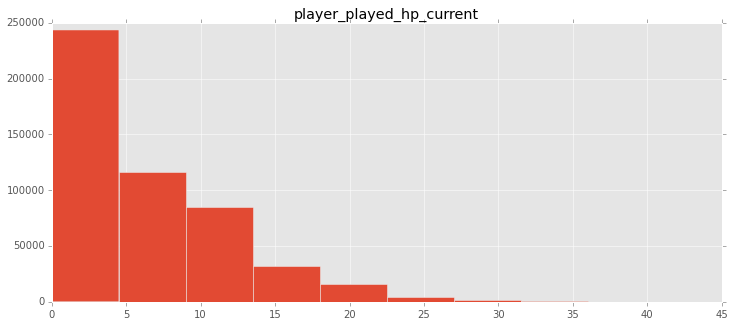

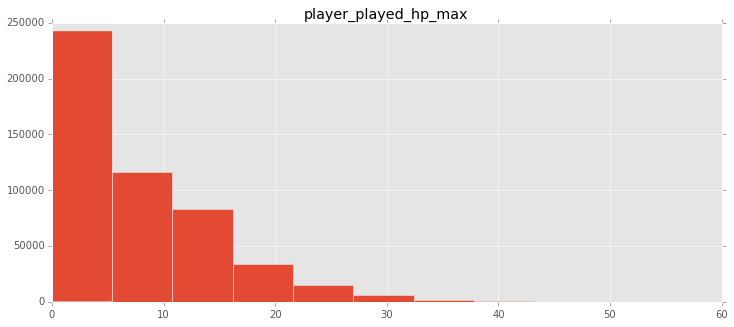

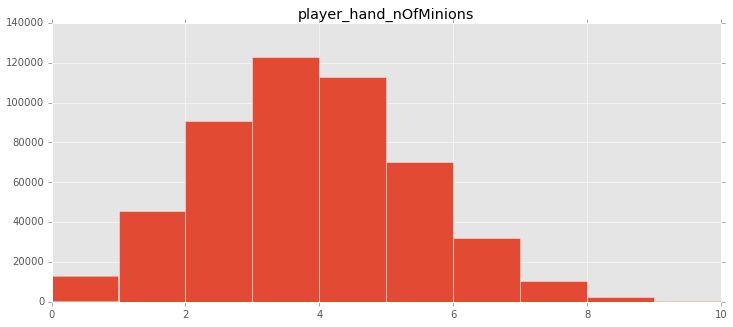

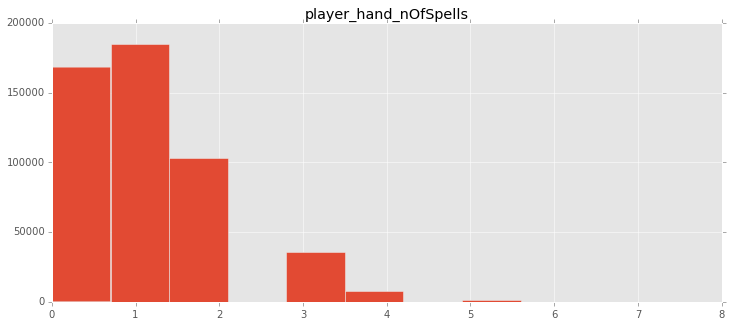

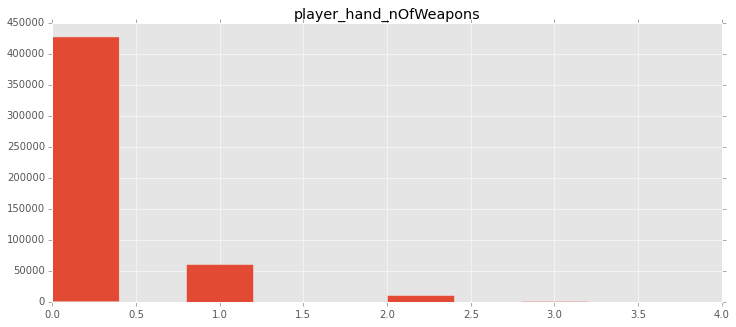

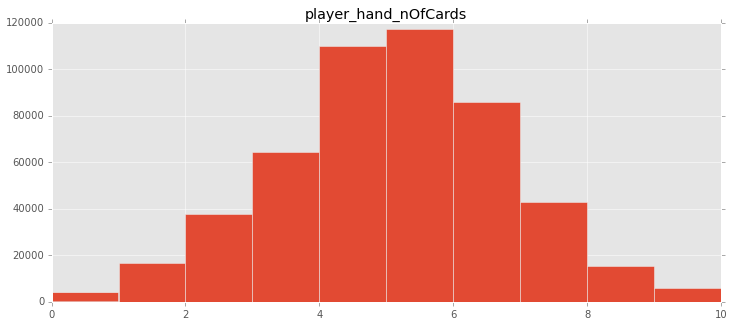

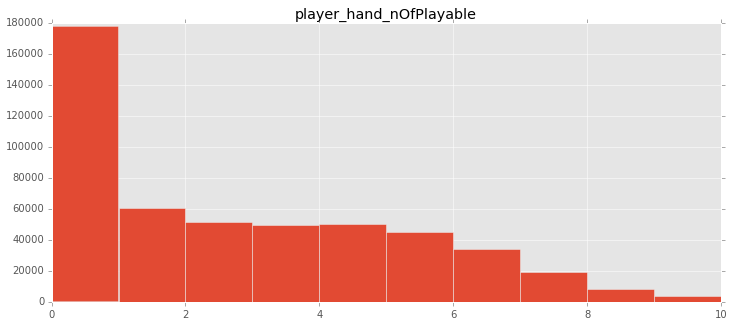

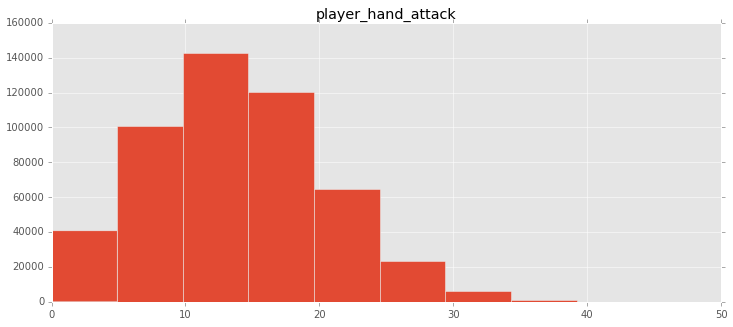

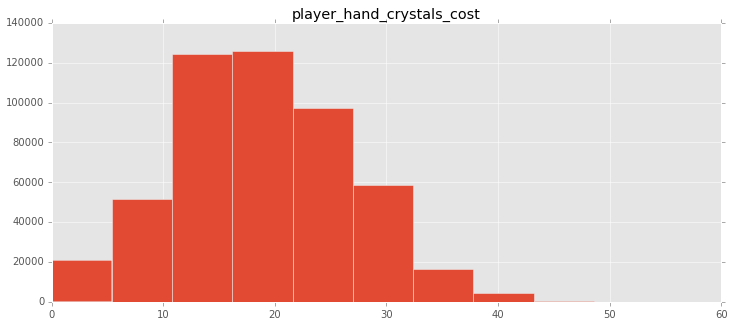

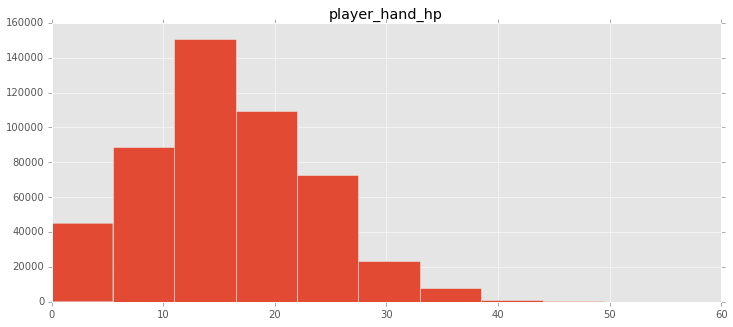

In [19]:
# column names are not self-explanatory at all
# let's guess whether a column is numeric or categorial by looking at its distribution
for v in df_data.columns:
    plt.figure()
    plt.title(v)
    df_data[v].hist()

In [42]:
from sklearn.preprocessing import OneHotEncoder

categorial_columns = [
    "opponent_attack", "opponent_hero_card_id", "opponent_special_skill_used",
    "player_attack", "player_hero_card_id", "player_special_skill_used"
]
numeric_columns = [
    "turn", "opponent_armor", "opponent_hp", "opponent_weapon_durability", "opponent_crystals_all",
    "opponent_crystals_current", "opponent_deck_count", "opponent_hand_count", "opponent_played_minions_count",
    "player_armor", "player_hp", "player_weapon_durability", "player_crystals_all", "player_crystals_current",
    "player_deck_count", "opponent_fatigue_damage", "player_fatigue_damage", "player_hand_count",
    "player_played_minions_count", "opponent_played_nOfCards", "opponent_played_attack",
    "opponent_played_crystals_cost", "opponent_played_hp_current", "opponent_played_hp_max",
    "player_played_nOfCards", "player_played_attack", "player_played_crystals_cost", "player_played_hp_current",
    "player_played_hp_max", "player_hand_nOfMinions", "player_hand_nOfSpells", "player_hand_nOfWeapons",
    "player_hand_nOfCards", "player_hand_nOfPlayable", "player_hand_attack", "player_hand_crystals_cost",
    "player_hand_hp"
]

def prepare_hs_data(df):
    return np.c_[
        OneHotEncoder(sparse=False).fit_transform(df[categorial_columns].values),
        df[numeric_columns].values
    ]

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [52]:
%%time
y = df_data.decision.values
X = prepare_hs_data(df_data)
hs_model = MySGDClassifier(max_epoch=1).fit(X,y) # I can 

0 Sun Apr 16 15:46:37 2017 34.910248892 [ 0.93712325  0.04210591  0.08588296  0.96585742  0.17323315  0.00494921
  0.49207544  0.49249125  0.85643018  0.04953232  0.8557428   0.76716269
  0.11278371  0.6058556   0.55258534  0.22654009  0.38832587  0.63523158
  0.40280179  0.39510557  0.15438181  0.85521865  0.09731137  0.38742733
  0.01394165  0.86179617  0.46511887  0.40762771  0.44913846  0.61272902
  0.58039931  0.68690992  0.05360633  0.14085474  0.8442823   0.36580337
  0.61342001  0.35632558  0.22390923  0.44596078  0.35601741  0.80944865
  0.46982332  0.89677005  0.56607921  0.54760013  0.62863547  0.86114185
  0.0966366   0.88439268  0.97583067  0.30852907  0.03159004  0.08989566
  0.34732357  0.24403323  0.34837436  0.73007688  0.84616638  0.29794847
  0.19051738  0.90871961  0.63961273  0.40410986  0.40793447  0.5341508
  0.20865359  0.49610681  0.09254859  0.96629842  0.18280318  0.67427951
  0.85921206  0.00769504]


KeyboardInterrupt: 

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [8]:
# XXX: this OOMs desktop
test_data = prepare_hs_data(pd.read_csv("testData_tabular.csv.gz"))
test_data_df.shape

(750000, 45)

In [ ]:
results = hs_model.predict_proba(test_data)